In [1]:
!pip install pandas
!pip install nltk
!pip install scikit-learn
!pip install spacy
!pip install tensorflow
!pip install keras-tuner
!pip install scipy
!pip install matplotlib
!pip install gensim
!pip install numpy

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.9/40.9 kB 1.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 15.7 MB/s eta 0:00:00:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 775.1/775.1 kB 10.2 MB/s eta 0:00:0000:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 301.8/301.8 kB 7.3 MB/s eta 0:00:00:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.6/60.6 kB 2.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.3/13.3 MB 42.0 MB/s eta 0:00:00:00:010:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 38.6/38.6 MB 46.8 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.6/6.6 MB 42.9 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.1/46.1 kB 949.2 kB/s eta 0:00:00 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 182.0/182.0 kB 4.4 MB/s eta 0:00:00ta 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 156.9/156.9 kB 5.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.0/57.0 kB 2.2

In [2]:
import re
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
import spacy
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, BatchNormalization, InputLayer
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping
from keras.regularizers import l2
from keras_tuner import RandomSearch
from kerastuner.engine.hyperparameters import HyperParameters
from scipy.sparse import csr_matrix
import tensorflow as tf
from tensorflow.keras.layers import InputLayer, Dense, BatchNormalization, Dropout
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping, LearningRateScheduler

/tmp/ipykernel_205/3882929971.py:25: DeprecationWarning: `import kerastuner` is deprecated, please use `import keras_tuner`.
  from kerastuner.engine.hyperparameters import HyperParameters


In [3]:
df = pd.read_csv('news_preprocessed.csv')
# Using 50% of the cleaned dataset:
# df_sample = df.sample(frac=0.5, random_state=42)

In [4]:
# Using TF-IDF Vectorizer
tfidf_vectorizer = TfidfVectorizer()
X_tfidf = tfidf_vectorizer.fit_transform(df['news'])

# Initialize LabelEncoder
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(df['category'])

# # One-hot encode the target variable
# y_dummies = pd.get_dummies(df_sample['category'], drop_first=True)

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X_tfidf, y_encoded, test_size=0.2, random_state=42)

In [5]:
# MLP TO RUN 
# Dense
# Convert sparse matrices to dense arrays
X_train_dense = X_train.toarray()
X_test_dense = X_test.toarray()

def build_model(hp):
    model = Sequential()
    model.add(InputLayer(input_shape=(X_train_dense.shape[1],)))
    model.add(BatchNormalization())  # Batch normalization layer

    for i in range(hp.Int('num_layers', 2, 5)):
        model.add(Dense(
            units=hp.Int(f'layer_{i}_units', min_value=32, max_value=512, step=32),
            activation=hp.Choice('activation', ['relu', 'tanh']),
            kernel_regularizer=l2(hp.Float('l2', min_value=1e-5, max_value=1e-2, sampling='log'))))
        model.add(Dropout(hp.Float('dropout_rate', min_value=0, max_value=0.5, step=0.1)))

    # Output layer with units equal to the number of classes and softmax activation
    model.add(Dense(len(label_encoder.classes_), activation='softmax'))

    model.compile(
        optimizer=Adam(learning_rate=hp.Choice('learning_rate', [0.001, 0.0001, 0.00001])),
        loss='sparse_categorical_crossentropy',  # Use sparse categorical crossentropy for label encoded targets
        metrics=['accuracy']
    )
    return model

tuner = RandomSearch(
    build_model,
    objective='val_accuracy',
    max_trials=30,
    executions_per_trial=1,
    directory='NLP',
    project_name='mlpsearch'
)

# add early stopping
early_stopping = EarlyStopping(
    monitor="val_loss", patience=5, restore_best_weights=True
)

# Use dense input data for training and evaluation
tuner.search(
    X_train_dense, y_train, epochs=10, validation_split=0.2, callbacks=[early_stopping]
)

best_hyperparameters = tuner.get_best_hyperparameters(num_trials=1)[0]
print("Best Hyperparameters:")
print(best_hyperparameters.values)

# print the best hyperparameters
print(best_hyperparameters)

best_model = tuner.get_best_models(num_models=1)[0]
best_model.summary()

loss, test_accuracy = best_model.evaluate(X_test_dense, y_test)
print("Test Accuracy:", test_accuracy)

Reloading Tuner from NLP/mlpsearch/tuner0.json
Best Hyperparameters:
{'num_layers': 2, 'layer_0_units': 96, 'activation': 'tanh', 'l2': 0.001118719966247768, 'dropout_rate': 0.1, 'layer_1_units': 480, 'learning_rate': 1e-05, 'layer_2_units': 352, 'layer_3_units': 32, 'layer_4_units': 288}


/opt/conda/lib/python3.10/site-packages/keras/src/layers/core/input_layer.py:25: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/keras/src/saving/saving_lib.py:415: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 18 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ batch_normalization             │ (None, 63277)          │       253,108 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 96)             │     6,074,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 96)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 480)            │        46,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 480)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 11)             │         5,291 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,379,647 (24.34 MB)

 Trainable params: 6,253,093 (23.85 MB)

 Non-trainable params: 126,554 (494.35 KB)

896/896 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.7923 - loss: 0.9317
Test Accuracy: 0.7905450463294983


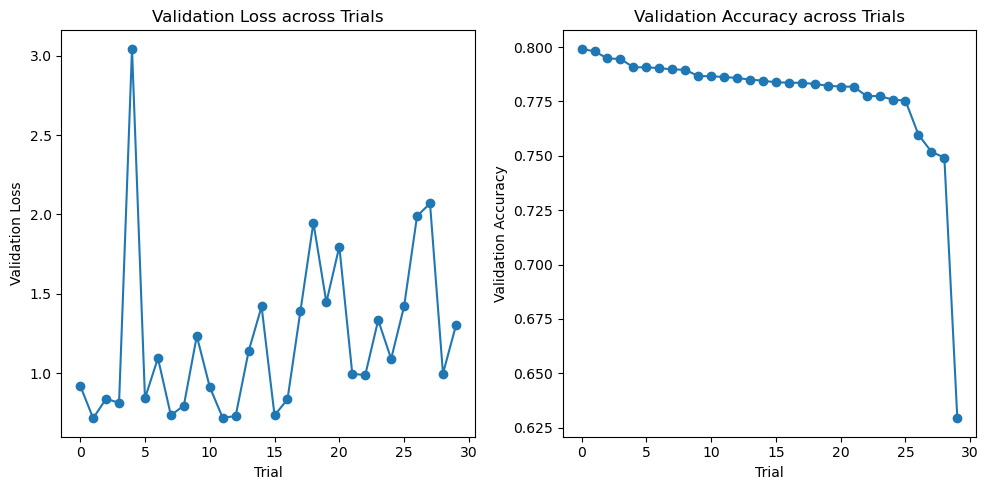

In [6]:
# Ploting the tuner results
trials = tuner.oracle.get_best_trials(num_trials=30)
val_losses = [trial.metrics.get_best_value('val_loss') for trial in trials]
val_accuracies = [trial.metrics.get_best_value('val_accuracy') for trial in trials]

# we plot both validation loss and accuracy
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(val_losses, marker='o')
plt.xlabel('Trial')
plt.ylabel('Validation Loss')
plt.title('Validation Loss across Trials')

plt.subplot(1, 2, 2)
plt.plot(val_accuracies, marker='o')
plt.xlabel('Trial')
plt.ylabel('Validation Accuracy')
plt.title('Validation Accuracy across Trials')

plt.tight_layout()
plt.show()

In [18]:
# Best hyperparameters
best_hyperparameters = {
    'num_layers': 2, 
    'layer_0_units': 96, 
    'activation': 'tanh', 
    'l2': 0.001118719966247768, 
    'dropout_rate': 0.1, 
    'layer_1_units': 480, 
    'learning_rate': 1e-05
    # Not used hyperparameters 'layer_2_units', 'layer_3_units', 'layer_4_units' since num_layers is 2
}

# Build the model using the best hyperparameters
def build_best_model():
    model = Sequential()
    model.add(InputLayer(input_shape=(X_train_dense.shape[1],)))
    model.add(BatchNormalization())  # Batch normalization layer

    for i in range(best_hyperparameters['num_layers']):
        model.add(Dense(
            units=best_hyperparameters[f'layer_{i}_units'],
            activation=best_hyperparameters['activation'],
            kernel_regularizer=l2(best_hyperparameters['l2'])))
        model.add(Dropout(best_hyperparameters['dropout_rate']))

    # Output layer with units equal to the number of classes and softmax activation
    model.add(Dense(len(label_encoder.classes_), activation='softmax'))

    model.compile(
        optimizer=Adam(learning_rate=best_hyperparameters['learning_rate']),
        loss='sparse_categorical_crossentropy',  # Use sparse categorical crossentropy for label encoded targets
        metrics=['accuracy']
    )
    return model

best_model = build_best_model()

# Print the model summary
best_model.summary()

# Early stopping implemented with patience 5
early_stopping = EarlyStopping(
    monitor="val_loss", patience=5, restore_best_weights=True
)

# Record the start time for training
start_time = time.time()

# training the model
history = best_model.fit(
    X_train_dense.astype("float32"),
    y_train,
    epochs=30,
    callbacks=[early_stopping],
    validation_data=(X_test_dense.astype("float32"), y_test)
)

# Record the end time after training ends
end_time = time.time()

# Calculate the total running time
runtime = end_time - start_time
print(f"Training time: {runtime:.2f} seconds")

# print accuracy and evaluation
loss, test_accuracy = best_model.evaluate(X_test_dense, y_test)
print("Test Accuracy:", test_accuracy)

Model: "sequential_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ batch_normalization_8           │ (None, 63277)          │       253,108 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_24 (Dense)                │ (None, 96)             │     6,074,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_16 (Dropout)            │ (None, 96)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_25 (Dense)                │ (None, 480)            │        46,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_17 (Dropout)            │ (None, 480)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_26 (Dense)                │ (None, 11)             │         5,291 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,379,647 (24.34 MB)

 Trainable params: 6,253,093 (23.85 MB)

 Non-trainable params: 126,554 (494.35 KB)

Epoch 1/30
3580/3580 ━━━━━━━━━━━━━━━━━━━━ 93s 23ms/step - accuracy: 0.3330 - loss: 2.2977 - val_accuracy: 0.7203 - val_loss: 1.2003
Epoch 2/30
3580/3580 ━━━━━━━━━━━━━━━━━━━━ 77s 21ms/step - accuracy: 0.7114 - loss: 1.2564 - val_accuracy: 0.7811 - val_loss: 0.9519
Epoch 3/30
3580/3580 ━━━━━━━━━━━━━━━━━━━━ 77s 22ms/step - accuracy: 0.7833 - loss: 0.9595 - val_accuracy: 0.7925 - val_loss: 0.9223
Epoch 4/30
3580/3580 ━━━━━━━━━━━━━━━━━━━━ 74s 21ms/step - accuracy: 0.8135 - loss: 0.8406 - val_accuracy: 0.7947 - val_loss: 0.9242
Epoch 5/30
3580/3580 ━━━━━━━━━━━━━━━━━━━━ 75s 21ms/step - accuracy: 0.8300 - loss: 0.7722 - val_accuracy: 0.7941 - val_loss: 0.9333
Epoch 6/30
3580/3580 ━━━━━━━━━━━━━━━━━━━━ 73s 21ms/step - accuracy: 0.8437 - loss: 0.7170 - val_accuracy: 0.7945 - val_loss: 0.9403
Epoch 7/30
3580/3580 ━━━━━━━━━━━━━━━━━━━━ 73s 20ms/step - accuracy: 0.8576 - loss: 0.6685 - val_accuracy: 0.7939 - val_loss: 0.9519
Epoch 8/30
3580/3580 ━━━━━━━━━━━━━━━━━━━━ 74s 21ms/step - accuracy: 0.8650 -

In [19]:
# predictions on the test data
predictions = best_model.predict(X_test_dense)

# evaluate the model
loss, test_accuracy = best_model.evaluate(X_test_dense, y_test)

# print accuracy and loss
print("Test Accuracy:", test_accuracy)
print("Test Loss:", loss)

896/896 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step
896/896 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.7932 - loss: 0.9128
Test Accuracy: 0.792465329170227
Test Loss: 0.9223291873931885


In [20]:
# Convert predictions to category labels
predicted_classes = predictions.argmax(axis=1)

# classification report
print(classification_report(y_test, predicted_classes, target_names=label_encoder.classes_))

# confusion matrix
conf_matrix = confusion_matrix(y_test, predicted_classes)
print(conf_matrix)

                     precision    recall  f1-score   support

ART & ENTERTAINMENT       0.79      0.79      0.79      4320
    BUSINESS & TECH       0.69      0.63      0.66      1705
        ENVIRONMENT       0.68      0.42      0.52       707
         GASTRONOMY       0.79      0.86      0.82      1643
          PARENTING       0.78      0.74      0.76      2479
           POLITICS       0.86      0.85      0.86      6602
             SPORTS       0.74      0.74      0.74       848
     STYLE & BEAUTY       0.84      0.83      0.84      2240
             TRAVEL       0.76      0.82      0.79      1897
           WELLNESS       0.79      0.84      0.81      4599
         WORLD NEWS       0.70      0.75      0.72      1601

           accuracy                           0.79     28641
          macro avg       0.76      0.75      0.75     28641
       weighted avg       0.79      0.79      0.79     28641

[[3403   43    8   59  126  224   58  151   80  127   41]
 [  77 1067   12   32   

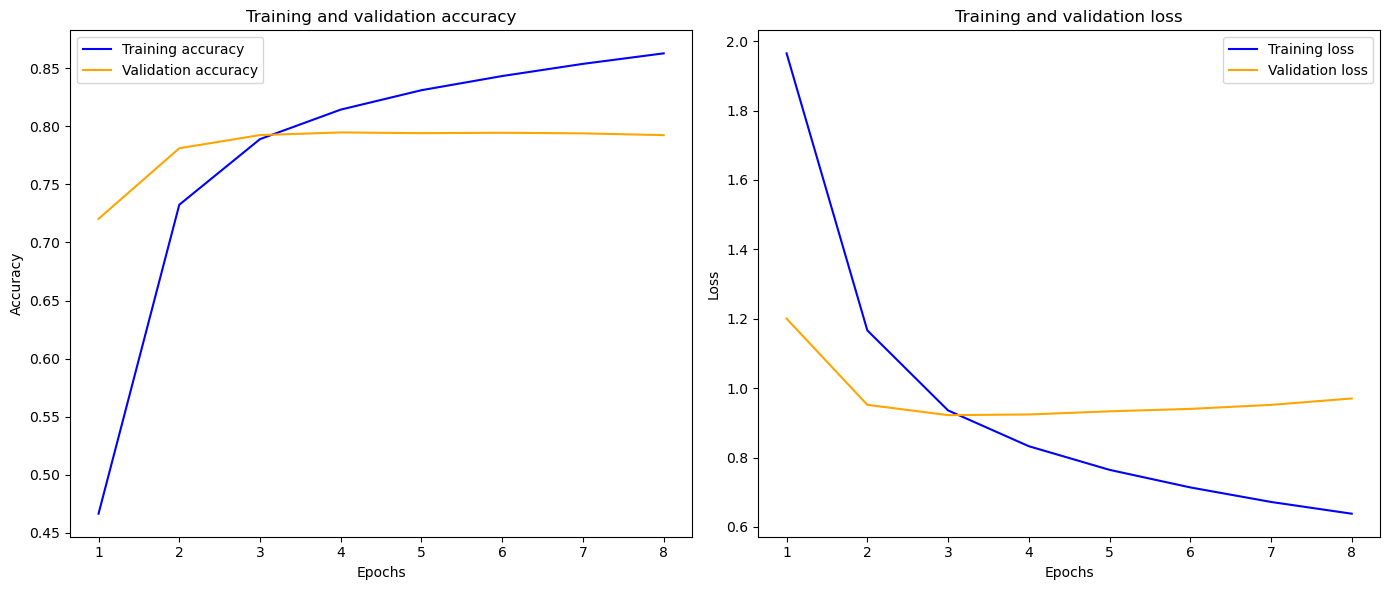

In [21]:
# get accuracy and loss plots:
history_dict = history.history
accuracy = history_dict["accuracy"]
val_accuracy = history_dict["val_accuracy"]
loss = history_dict["loss"]
val_loss = history_dict["val_loss"]

# determine the number of epochs
epochs = range(1, len(accuracy) + 1)

plt.figure(figsize=(14, 6))

# plot training and validation accuracy:

plt.subplot(1, 2, 1)
plt.plot(epochs, accuracy, "b-", label="Training accuracy")
plt.plot(epochs, val_accuracy, "orange", label="Validation accuracy")
plt.title("Training and validation accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()

# plot training and validation loss:
plt.subplot(1, 2, 2)
plt.plot(epochs, loss, "b-", label="Training loss")
plt.plot(epochs, val_loss, "orange", label="Validation loss")
plt.title("Training and validation loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()

plt.tight_layout()

# saving plots
plt.savefig("training_validation_plot_final_2.png")

plt.show()